# Step 1: Import Necessary Packages


In [0]:
import re #A regular expression (or RE) specifies a set of strings that matches it.
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string 
import nltk #Natural Language Processing Toolkit
from nltk.corpus import stopwords
from nltk import bigrams
from nltk import punkt
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import networkx as nx
from textblob import TextBlob
import itertools 
import collections

import warnings #Warnings control
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline 

import tweepy #Python library for accessing the Twitter API
from tweepy import OAuthHandler #open standard for token-based authentication and authorization on the Internet

import json

# Step 2: Authenticate Twitter API

In [0]:
# Connect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Create a variable to store the data path on your drive
path = '/content/drive/My Drive/Data Sets/Twitter Sentiment Analysis/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load Twitter API secrets from an external JSON file
secrets = json.loads(open(path + "secrets.json").read())
Twitter_API_Key = secrets['Twitter_API_Key']
Twitter_Secret_API_Key = secrets['Twitter_Secret_API_Key']
Twitter_Access_Token = secrets['Twitter_Access_Token']
Twitter_Secret_Access_Token = secrets['Twitter_Secret_Access_Token']

In [0]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(Twitter_API_Key, Twitter_Secret_API_Key)
auth.set_access_token(Twitter_Access_Token, Twitter_Secret_Access_Token)
api = tweepy.API(auth)

# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error During Authentication")

Authentication OK


#Step 3: Search and Collect Tweets

In [0]:
#Search Tweets
search_words = "Trump -filter:retweets"
date_since = "2019-11-16"

#Collect Tweets
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(1000)

all_tweets = [tweet.text for tweet in tweets]
all_tweets[:5]

['@RepEscobar @sweetleaner @realDonaldTrump @jack It’s a parody of Nancy’s antics during SOTU speech. You know, like… https://t.co/oJfehgiyPQ',
 'Trump do you really think anyone believes your tan and hair are real. Both are fake. Just like all your promises.',
 '@jfradioshow Trump is a vindictive fool. Worse world leader since Adolf Hitler.',
 'Trump supporters are being attacked on many levels &amp; you will not see Democratic leaders address it because they wa… https://t.co/uPFvSxGr0K',
 '@benjaminwittes If Alexander Vindman had violated a subpoena, he would have been court martialed. If he had lied fo… https://t.co/GKxecthXvQ']

# Step 4: Create Pandas DataFrame from Tweet Data

In [0]:
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(1000)

users_locs_tweets = [[tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

In [0]:
#Create a pandas dataframe from a list of tweet data
tweet_data = pd.DataFrame(data=users_locs_tweets, 
                    columns=["user", "location", "tweet"])
tweet_data

,user,location,tweet
0,1111Joey,,@RepEscobar @sweetleaner @realDonaldTrump @jac...
1,bjeanneschreib,,Trump do you really think anyone believes your...
2,F8BTHER,,@jfradioshow Trump is a vindictive fool. Worse...
3,EconomicSlave,"Hijacked Michigan, USA",Trump supporters are being attacked on many le...
4,MonicaRivpin,"London, England",@benjaminwittes If Alexander Vindman had viola...
...,...,...,...
995,William75403058,"Philadelphia, PA",@SarahKSilverman Name one way your life is wor...
996,Eric74565359,,@MNWvdL @POTUS @realDonaldTrump Everyone takes...
997,Mina_Espiritu,"SuperNatural B.C., Canada",@HiddenCash @JKCorden @latelateshow Eyes look ...
998,TiaBarracini,𝔻.ℂ.,As a percentage of the entire US population (i...


#Step 5: Pre Processing Data

In [0]:
# Create a function to remove patterns
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# remove twitter handles (@user)
tweet_data['clean_tweet'] = np.vectorize(remove_pattern)(tweet_data['tweet'], "@[\w]*")

# Create a function to remove URLs
def remove_url(tweet):
        return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())

#remove urls
tweet_data['clean_tweet'] = np.vectorize(remove_url)(tweet_data['clean_tweet'])


# remove special characters, numbers, punctuations
tweet_data['clean_tweet'] = tweet_data['clean_tweet'].str.replace("[^a-zA-Z#]", " ")

# remove short words
tweet_data['clean_tweet'] = tweet_data['clean_tweet'].apply(lambda x: ' '.join(word for word in x.split() if len(word)>3))

# normalizing case
tweet_data['clean_tweet'] = tweet_data['clean_tweet'].apply(lambda x: x.lower())

tweet_data

,user,location,tweet,clean_tweet
0,1111Joey,,@RepEscobar @sweetleaner @realDonaldTrump @jac...,parody nancys antics during sotu speech know like
1,bjeanneschreib,,Trump do you really think anyone believes your...,trump really think anyone believes your hair r...
2,F8BTHER,,@jfradioshow Trump is a vindictive fool. Worse...,trump vindictive fool worse world leader since...
3,EconomicSlave,"Hijacked Michigan, USA",Trump supporters are being attacked on many le...,trump supporters being attacked many levels wi...
4,MonicaRivpin,"London, England",@benjaminwittes If Alexander Vindman had viola...,alexander vindman violated subpoena would have...
...,...,...,...,...
995,William75403058,"Philadelphia, PA",@SarahKSilverman Name one way your life is wor...,name your life worse than before trump elected...
996,Eric74565359,,@MNWvdL @POTUS @realDonaldTrump Everyone takes...,everyone takes picture some angle gosh even of...
997,Mina_Espiritu,"SuperNatural B.C., Canada",@HiddenCash @JKCorden @latelateshow Eyes look ...,eyes look like trump
998,TiaBarracini,𝔻.ℂ.,As a percentage of the entire US population (i...,percentage entire population including those y...


In [0]:
nltk.download('punkt')
#Tokenization
tokenized_tweet = tweet_data['clean_tweet'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    [parody, nancys, antics, during, sotu, speech,...
1    [trump, really, think, anyone, believes, your,...
2    [trump, vindictive, fool, worse, world, leader...
3    [trump, supporters, being, attacked, many, lev...
4    [alexander, vindman, violated, subpoena, would...
Name: clean_tweet, dtype: object

In [0]:
# Remove words used to collect data (or simialr words)
collection_words = ['trump', 'donald', 'realdonaldtrump', 'president', 'trumps']
tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in collection_words])
tokenized_tweet.head()

0    [parody, nancys, antics, during, sotu, speech,...
1    [really, think, anyone, believes, your, hair, ...
2    [vindictive, fool, worse, world, leader, since...
3    [supporters, being, attacked, many, levels, wi...
4    [alexander, vindman, violated, subpoena, would...
Name: clean_tweet, dtype: object

In [0]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
# View a few words from the set
list(stop_words)[0:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['why', 'do', 'into', 'me', 'yourselves', 'own', 'd', 'while', 'who', 'these']

In [0]:
# Remove stop words. These are commonly appearing words that provide no information such as who, what why etc
tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_tweet.head()

0    [parody, nancys, antics, sotu, speech, know, l...
1    [really, think, anyone, believes, hair, real, ...
2    [vindictive, fool, worse, world, leader, since...
3    [supporters, attacked, many, levels, democrati...
4    [alexander, vindman, violated, subpoena, would...
Name: clean_tweet, dtype: object

In [0]:
nltk.download('wordnet')
#lemmetizing
lemmer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmer.lemmatize(i) for i in x])
tokenized_tweet.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0     [parody, nancy, antic, sotu, speech, know, like]
1    [really, think, anyone, belief, hair, real, fa...
2    [vindictive, fool, worse, world, leader, since...
3    [supporter, attacked, many, level, democratic,...
4    [alexander, vindman, violated, subpoena, would...
Name: clean_tweet, dtype: object

In [0]:
#Stemming (stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer("english")
#tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
#tokenized_tweet.head()

# Step 7: Word Frequency in Clean Tweets

In [0]:
# Flatten list of words in clean tweets
tokenized_tweet_flat = list(itertools.chain(*tokenized_tweet))

# Create counter of words in clean tweets
tokenized_tweet_word_count = collections.Counter(tokenized_tweet_flat)

#number of unique words across all tweets
len(tokenized_tweet_word_count)

2680

In [0]:
# Create a data table
tokenized_tweet_data = pd.DataFrame(tokenized_tweet_word_count.most_common(15),
                             columns=['words', 'count'])
tokenized_tweet_data.head()


,words,count
0,like,57
1,think,42
2,would,41
3,people,41
4,know,40


<Figure size 1008x360 with 0 Axes>

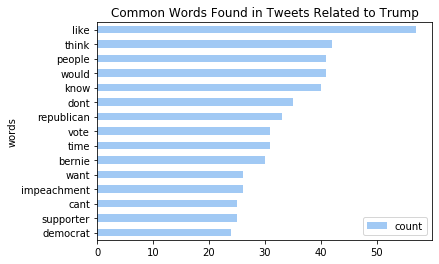

In [0]:
# Plot horizontal bar graph
sns.set_palette('pastel')
plt.figure(figsize=(14,5))
#sns.barplot('words', 'count', data=tokenized_tweet_data, orient='h')
tokenized_tweet_data.sort_values(by='count').plot.barh(x='words', y='count')
plt.title('Common Words Found in Tweets Related to Trump')

plt.show()

#Step 8: Explore Co-occuring words (Bigrams)

In [0]:
terms_bigram = [list(bigrams(tweet)) for tweet in tokenized_tweet]
terms_bigram[0]

[('parody', 'nancy'),
 ('nancy', 'antic'),
 ('antic', 'sotu'),
 ('sotu', 'speech'),
 ('speech', 'know'),
 ('know', 'like')]

In [0]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('white', 'house'), 9),
 (('impeachment', 'witness'), 8),
 (('gon', 'na'), 8),
 (('secret', 'service'), 6),
 (('fake', 'news'), 6),
 (('impeachment', 'trial'), 5),
 (('look', 'like'), 5),
 (('stop', 'firing'), 5),
 (('republican', 'party'), 5),
 (('united', 'state'), 5),
 (('dont', 'know'), 4),
 (('dont', 'think'), 4),
 (('dont', 'like'), 4),
 (('senator', 'tried'), 4),
 (('tried', 'stop'), 4),
 (('firing', 'impeachment'), 4),
 (('really', 'think'), 3),
 (('alexander', 'vindman'), 3),
 (('nancy', 'pelosi'), 3),
 (('dont', 'want'), 3)]

#Step 9: Create a Bigram Data Table and Chart

In [0]:
bigram_data = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_data

,bigram,count
0,"(white, house)",9
1,"(impeachment, witness)",8
2,"(gon, na)",8
3,"(secret, service)",6
4,"(fake, news)",6
5,"(impeachment, trial)",5
6,"(look, like)",5
7,"(stop, firing)",5
8,"(republican, party)",5
9,"(united, state)",5


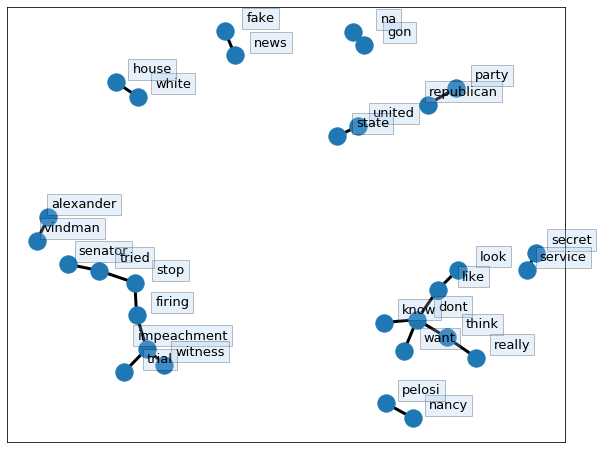

In [0]:
# Create dictionary of bigrams and their counts
d = bigram_data.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

#G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 #edge_color='grey',
                 #node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

#Step 10: Stitch together the tokenized tweets

In [0]:
un_tokenized_tweet = tokenized_tweet.apply(lambda x: " ".join(x))
un_tokenized_tweet.head()

0             parody nancy antic sotu speech know like
1    really think anyone belief hair real fake like...
2    vindictive fool worse world leader since adolf...
3    supporter attacked many level democratic leade...
4    alexander vindman violated subpoena would cour...
Name: clean_tweet, dtype: object

In [0]:
tweet_data['clean_tweet'] = un_tokenized_tweet
tweet_data

,user,location,tweet,clean_tweet
0,1111Joey,,@RepEscobar @sweetleaner @realDonaldTrump @jac...,parody nancy antic sotu speech know like
1,bjeanneschreib,,Trump do you really think anyone believes your...,really think anyone belief hair real fake like...
2,F8BTHER,,@jfradioshow Trump is a vindictive fool. Worse...,vindictive fool worse world leader since adolf...
3,EconomicSlave,"Hijacked Michigan, USA",Trump supporters are being attacked on many le...,supporter attacked many level democratic leade...
4,MonicaRivpin,"London, England",@benjaminwittes If Alexander Vindman had viola...,alexander vindman violated subpoena would cour...
...,...,...,...,...
995,William75403058,"Philadelphia, PA",@SarahKSilverman Name one way your life is wor...,name life worse elected paranoia course
996,Eric74565359,,@MNWvdL @POTUS @realDonaldTrump Everyone takes...,everyone take picture angle gosh even offering...
997,Mina_Espiritu,"SuperNatural B.C., Canada",@HiddenCash @JKCorden @latelateshow Eyes look ...,eye look like
998,TiaBarracini,𝔻.ℂ.,As a percentage of the entire US population (i...,percentage entire population including young i...


# Step 11: Create Word Cloud

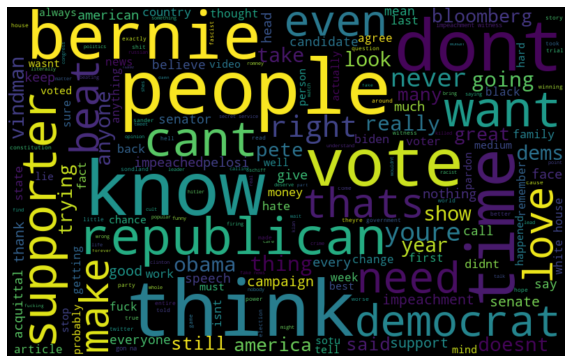

In [0]:
all_words = ' '.join([text for text in tweet_data['clean_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Step 12: Analyze Sentiments in Tweets

In [0]:
# Create textblob objects of the tweets
sentiment_objects = [TextBlob(tweet) for tweet in un_tokenized_tweet]

sentiment_objects[0].polarity, sentiment_objects[0]

(0.0, TextBlob("parody nancy antic sotu speech know like"))

In [0]:
# Create list of polarity values and tweet text
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

sentiment_values[0]

[0.0, 'parody nancy antic sotu speech know like']

In [0]:
# Create dataframe containing the polarity value and tweet text
sentiment_data = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_data.head()

,polarity,tweet
0,0.000,parody nancy antic sotu speech know like
1,-0.275,really think anyone belief hair real fake like...
2,-0.400,vindictive fool worse world leader since adolf...
3,0.500,supporter attacked many level democratic leade...
4,0.000,alexander vindman violated subpoena would cour...


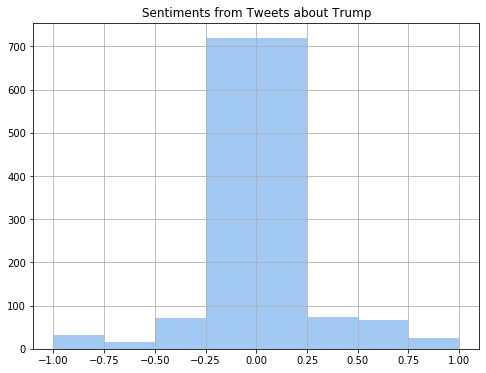

In [0]:
# Plot histogram of the polarity values

fig, ax = plt.subplots(figsize=(8, 6))
sentiment_data.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax)

plt.title("Sentiments from Tweets about Trump")
plt.show()

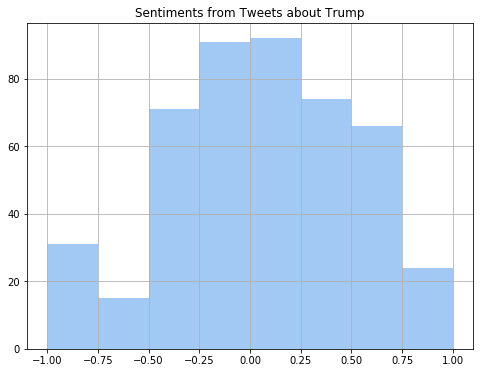

In [0]:
# Remove polarity values equal to zero
sentiment_data = sentiment_data[sentiment_data.polarity != 0]

# Plot histogram with break at zero

fig, ax = plt.subplots(figsize=(8, 6))
sentiment_data.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax)

plt.title("Sentiments from Tweets about Trump")
plt.show()

# Step 13: Analyze Sentiments through Hashtags

In [0]:
# function to collect hashtags
def hashtag_collection(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

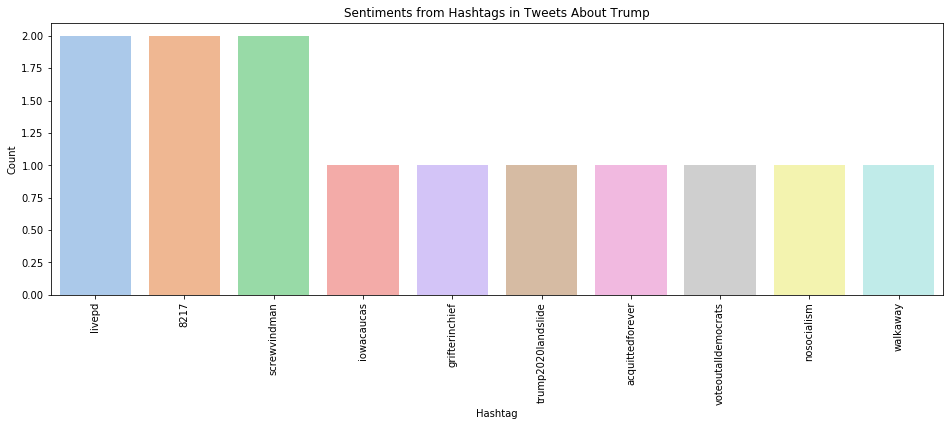

In [0]:
# extracting hashtags
hashtag = hashtag_collection(tweet_data['tweet'])

# unnesting list
hashtag = sum(hashtag,[])

a = nltk.FreqDist(hashtag)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# normalizing case
d['Hashtag'] = d['Hashtag'].apply(lambda x: x.lower())

# removing selection hashtags
d = d[(d.Hashtag != 'trump') &  (d.Hashtag != 'donald') & (d.Hashtag != 'realdonaldtrump') & (d.Hashtag != 'president') & (d.Hashtag != 'trumps')]

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.title('Sentiments from Hashtags in Tweets About Trump')
plt.show()